In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from tqdm.notebook import tqdm

from statsmodels.tsa.stattools import acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import timealter as ta

sns.set_theme('notebook', 'darkgrid', 'colorblind')
warnings.filterwarnings("ignore")

# Sample time series datasets

In [3]:
# Load champagne data
ts = pd.read_csv('champagne.csv', index_col='Month').squeeze()
ts.index = pd.to_datetime(ts.index)
ts_copy = ts.copy()

# Synthesizing missing datapoints for demonstration
ts.iloc[[24, 33, 55]] = np.nan

# Dataset for DateTimeIndex demonstration
ts_d = ts.copy()

# Dataset for PeriodIndex demonstration
ts_p = ts.copy()
ts_p.drop(index=['1966-04-01', '1966-08-01'], inplace=True)
ts_p.index = ts_p.index.to_period('M')

# Dataset for pipeline demonstration
ts_elec = pd.read_csv('elecdaily_mm.csv', index_col='Date')
ts_elec.index = pd.to_datetime(ts_elec.index)

Run the AutoARIMA pipeline below using:
1. `ts_d` : to explore the pipeline using a dataset with `DatetimeIndex` as index with missing data and missing dates.
1. `ts_p` : to explore the pipeline using a dataset with `PeriodIndex` as index with missing data.
1. `ts_elec` : to explore the pipeline using a clean dataset.

# Demonstration

## `DatetimeIndex` demo

In [4]:
date_champagne = ta.TimeAlter(ts_d, freq='MS', h=6, cv=5, test_sets=3)

There are 3 missing values.


In [5]:
date_champagne.impute(method='interpolate')

Missing values have been imputed.


## `PeriodIndex` demo

In [6]:
period_champagne = ta.TimeAlter(ts_p, freq='M', h=6, cv=5, test_sets=3)

Time series has missing dates. Index has been updated.
There are 5 missing values.


In [7]:
date_champagne.impute(method='ffill')

There are no missing values to fill.


## Pipeline demo

In [8]:
# Instantiate class.
# Prints a warning if there are missing values/dates. Use impute method to fix

autots = ta.TimeAlter(ts_elec, freq='D', h=7, cv=24, test_sets=17)

In [9]:
# Impute dataset using ffill, bffill, or interpolate

autots.impute(method='ffill')

There are no missing values to fill.


In [10]:
# Split the dataset based on the cv and test_sets parameters defined during
# instantiation.
# This may be skipped if you plan to `transform` the time series.

autots.split()

In [11]:
# Get baseline MAE
#     Specify:
#         assumed seasonality (for seasonal naive)

autots.get_baseline(m=7)

{'naive_mae': 5.533142857142857, 'snaive_mae': 4.418836974789916}

ADF = -3.329862
p-value = 0.013595
The time series is probably stationary.


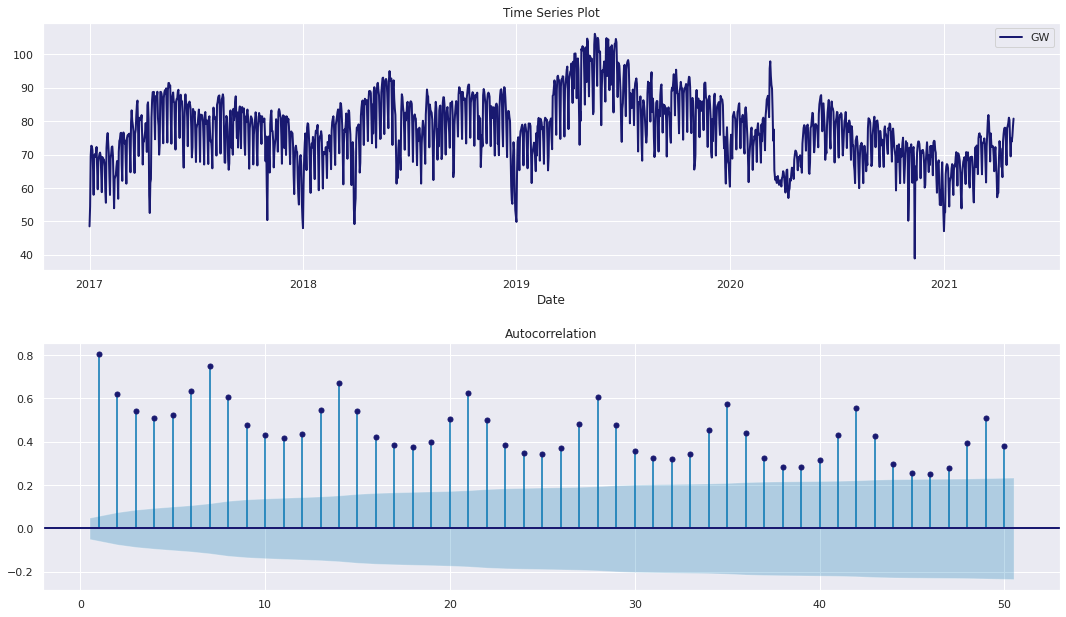

In [12]:
# Plot the time series and ACF plot and check its stationarity.

autots.eda();

In [13]:
# Transform the time series using log-transformation, differencing, or both.
# You can do multiple differencing by passing a list of integers to diff.
# ADF test is conducted on the resulting transformed series to check stationarity.

autots.transform(log=False, diff=7)

ADF = -9.752618
p-value = 0.000000
The time series is probably stationary.


,GW
Date,
2017-01-08,9.4607
2017-01-09,14.4105
2017-01-10,0.5109
2017-01-11,-3.3412
2017-01-12,-2.4459
...,...
2021-04-26,-3.1136
2021-04-27,-4.6761
2021-04-28,-3.8884


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

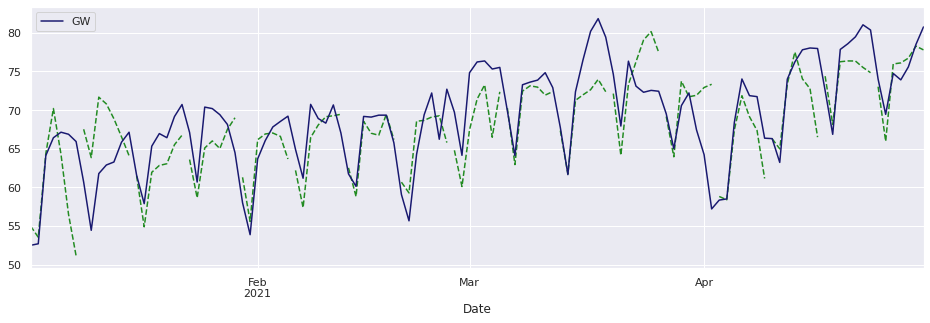

In [14]:
# Performs the grid search on ARIMA.

# Returns the average test MAE of the best estimator from the grid search
# on the test sets.

ave_test_mae = autots.arima_cv(param_grid=dict(p=[1, 2], d=[0], q=[1, 3]))

In [15]:
# Available after performing `arima_cv`
# cv_summary shows the result of the grid search

autots.cv_summary

,order_pdq,mean_mae
2,"(2, 0, 1)",4.076111
1,"(1, 0, 3)",4.165244
0,"(1, 0, 1)",4.207758
3,"(2, 0, 3)",4.246515
